In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from google.colab import files
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/FER-2013.zip"  # Change if needed
extract_to = "/content/FER-2013"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ FER-2013 extracted!")




✅ FER-2013 extracted!


In [ ]:
def load_images_and_labels(path):
    images, labels = [], []
    for emotion in os.listdir(path):
        emotion_folder = os.path.join(path, emotion)
        for img_file in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(emotion)
    return images, labels

In [ ]:
def oversample_classes(images, labels):
    class_data = defaultdict(list)
    for img, lbl in zip(images, labels):
        class_data[lbl].append(img)
    max_len = max(len(imgs) for imgs in class_data.values())

    balanced_images, balanced_labels = [], []
    for lbl, imgs in class_data.items():
        oversampled = imgs + random.choices(imgs, k=max_len - len(imgs))
        balanced_images.extend(oversampled)
        balanced_labels.extend([lbl] * max_len)
    return balanced_images, balanced_labels

In [ ]:
# Set paths
train_path = os.path.join(extract_to, "train")
test_path = os.path.join(extract_to, "test")

train_images, train_labels = load_images_and_labels(train_path)
test_images, test_labels = load_images_and_labels(test_path)

balanced_train_images, balanced_train_labels = oversample_classes(train_images, train_labels)

In [ ]:
# ----------- Image Generator for Batch Processing ----------- #
class ImageBatchGenerator(Sequence):
    def __init__(self, images, batch_size=64):
        self.images = images
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        processed = []
        for img in batch_images:
            img_resized = cv2.resize(img, (224, 224))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            img_rgb = img_rgb.astype(np.float32)
            processed.append(img_rgb)
        processed = np.array(processed)
        return preprocess_input(processed)


In [ ]:
# ----------- Feature Extraction ----------- #
print("Loading VGG16...")
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = Model(inputs=base_model.input, outputs=base_model.output)

# Training features
train_generator = ImageBatchGenerator(balanced_train_images, batch_size=64)
features_train = vgg_model.predict(train_generator, verbose=1)
X_train_features = features_train.reshape(features_train.shape[0], -1)

# Test features
test_generator = ImageBatchGenerator(test_images, batch_size=64)
features_test = vgg_model.predict(test_generator, verbose=1)
X_test_features = features_test.reshape(features_test.shape[0], -1)


Loading VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


790/790 ━━━━━━━━━━━━━━━━━━━━ 253s 296ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 337ms/step


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
# ----------- Label Encoding ----------- #
le = LabelEncoder()
y_train = le.fit_transform(balanced_train_labels)
y_test = le.transform(test_labels)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

pca = PCA(n_components=500, random_state=42)
X_train_reduced = pca.fit_transform(X_train_features)
X_test_reduced = pca.transform(X_test_features)

svm = LinearSVC(C=1, max_iter=5000, random_state=42)
svm.fit(X_train_reduced, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_features, y_train)

RandomForestClassifier(random_state=42)

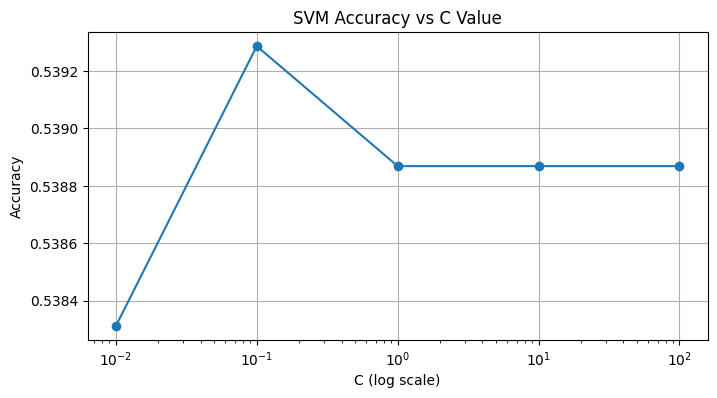

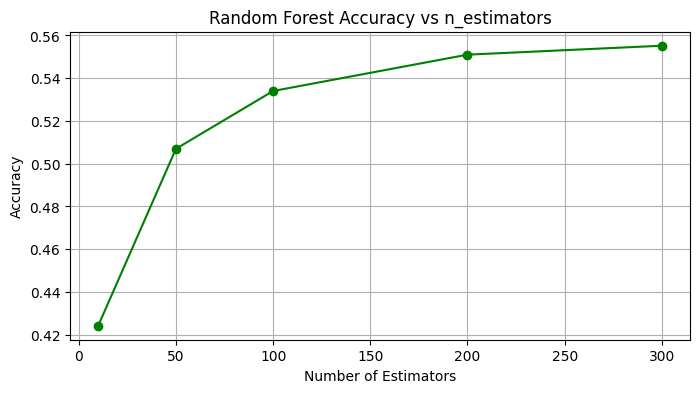

In [ ]:
# ================================
# 🔧 Hyperparameter Tuning (SVM & RF)
# ================================
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# --- SVM Tuning (on PCA-reduced features) ---
C_values = [0.01, 0.1, 1, 10, 100]
svm_accuracies = []

for C in C_values:
    svm = LinearSVC(C=C, max_iter=5000, random_state=42)
    svm.fit(X_train_reduced, y_train)
    y_pred = svm.predict(X_test_reduced)
    acc = accuracy_score(y_test, y_pred)
    svm_accuracies.append(acc)

plt.figure(figsize=(8, 4))
plt.plot(C_values, svm_accuracies, marker='o')
plt.xscale('log')
plt.title('SVM Accuracy vs C Value')
plt.xlabel('C (log scale)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# --- Random Forest Tuning (on original CNN features) ---
n_estimators_list = [10, 50, 100, 200, 300]
rf_accuracies = []

for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_features, y_train)
    y_pred = rf.predict(X_test_features)
    acc = accuracy_score(y_test, y_pred)
    rf_accuracies.append(acc)

plt.figure(figsize=(8, 4))
plt.plot(n_estimators_list, rf_accuracies, marker='o', color='green')
plt.title('Random Forest Accuracy vs n_estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [ ]:
# ----------- Evaluation ----------- #
y_pred_svm = svm.predict(X_test_reduced)
y_pred_rf = rf.predict(X_test_features)

print("\nSVM Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"RF Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"SVM F1 Score: {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"RF F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")


SVM Report:
              precision    recall  f1-score   support

       angry       0.45      0.43      0.44       958
     disgust       0.25      0.73      0.37       111
        fear       0.42      0.27      0.33      1024
       happy       0.73      0.76      0.75      1774
     neutral       0.49      0.53      0.51      1233
         sad       0.43      0.38      0.40      1247
    surprise       0.62      0.76      0.68       831

    accuracy                           0.54      7178
   macro avg       0.48      0.55      0.50      7178
weighted avg       0.54      0.54      0.53      7178


Random Forest Report:
              precision    recall  f1-score   support

       angry       0.50      0.32      0.39       958
     disgust       1.00      0.40      0.57       111
        fear       0.49      0.31      0.38      1024
       happy       0.56      0.82      0.67      1774
     neutral       0.47      0.47      0.47      1233
         sad       0.43      0.44      0.4

In [ ]:
# ----------- Train Set Evaluation ----------- #

# For SVM
y_train_pred_svm = svm.predict(X_train_reduced)
print("\nSVM Train Report:")
print(classification_report(y_train, y_train_pred_svm, target_names=le.classes_))
print(f"SVM Train Accuracy: {accuracy_score(y_train, y_train_pred_svm):.4f}")
print(f"SVM Train F1 Score: {f1_score(y_train, y_train_pred_svm, average='weighted'):.4f}")

# For Random Forest
y_train_pred_rf = rf.predict(X_train_features)
print("\nRandom Forest Train Report:")
print(classification_report(y_train, y_train_pred_rf, target_names=le.classes_))
print(f"RF Train Accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"RF Train F1 Score: {f1_score(y_train, y_train_pred_rf, average='weighted'):.4f}")



SVM Train Report:
              precision    recall  f1-score   support

       angry       0.54      0.47      0.50      7215
     disgust       0.82      0.96      0.88      7215
        fear       0.55      0.35      0.43      7215
       happy       0.65      0.77      0.70      7215
     neutral       0.52      0.58      0.55      7215
         sad       0.47      0.45      0.46      7215
    surprise       0.71      0.79      0.74      7215

    accuracy                           0.62     50505
   macro avg       0.61      0.62      0.61     50505
weighted avg       0.61      0.62      0.61     50505

SVM Train Accuracy: 0.6218
SVM Train F1 Score: 0.6101

Random Forest Train Report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00      7215
     disgust       1.00      1.00      1.00      7215
        fear       1.00      1.00      1.00      7215
       happy       1.00      1.00      1.00      7215
     neutral       1.00      1

<Figure size 800x600 with 0 Axes>

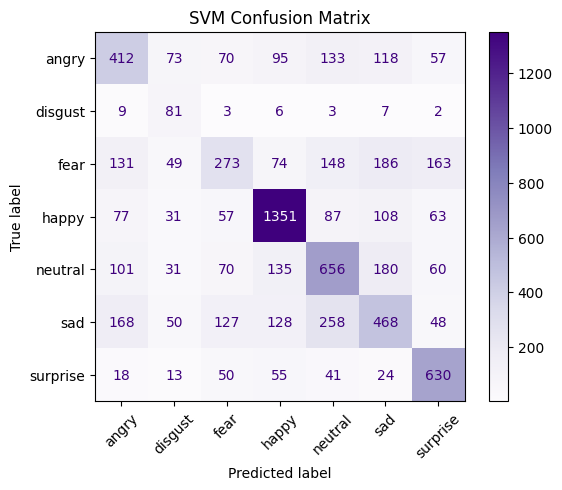

<Figure size 800x600 with 0 Axes>

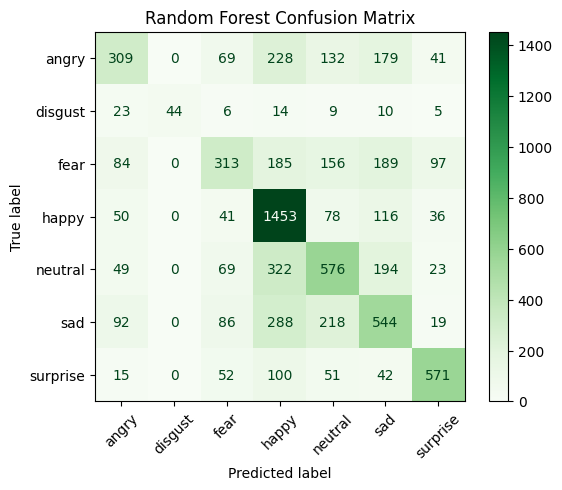

In [ ]:
# ----------- Confusion Matrices ----------- #
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=le.classes_)
plt.figure(figsize=(8, 6))
disp_svm.plot(cmap='Purples', xticks_rotation=45)
plt.title("SVM Confusion Matrix")
plt.grid(False)
plt.show()

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)
plt.figure(figsize=(8, 6))
disp_rf.plot(cmap='Greens', xticks_rotation=45)
plt.title("Random Forest Confusion Matrix")
plt.grid(False)
plt.show()
